In [1]:
!git clone https://github.com/ezaaputra/indonlu.git
# !pip install transformer

import os

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# NN
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AlbertForSequenceClassification
# from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from transformers import AutoTokenizer

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 19.96 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel("/content/drive/MyDrive/00. Drive PC/1.STIS/SEMNAS 2024/data_bert.xlsx")
#df = pd.read_excel("data_bert.xlsx")
df

,Unnamed: 0,Judul,Tanggal,Link,Berita,Kode,Label,Cleaned Berita,Unnamed: 8,Unnamed: 9
0,0,"ISHG Dibuka di Zona Hijau, Kembali ke Zona 7.2...",22 Mei 2024 09:13,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,1,ihsg naik,indeks harga saham gabungan (ihsg) pagi ini di...,NaN,Count
1,1,IHSG Dibuka di Zona Hijau Usai Kemarin Melempem,21 Mei 2024 09:12,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,1,ihsg naik,indeks harga saham gabungan (ihsg) pagi ini di...,NaN,1394
2,2,"Dibuka di Zona Hijau, IHSG Sore Ini Ditutup Me...",20 Mei 2024 16:31,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) menutup per...,0,ihsg turun,indeks harga saham gabungan (ihsg) menutup per...,NaN,1070
3,3,"IHSG Begitu Cerah, Awali Pekan di Zona Hijau",20 Mei 2024 09:10,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) mengawali p...,1,ihsg naik,indeks harga saham gabungan (ihsg) mengawali p...,NaN,NaN
4,4,Akhir Pekan IHSG Betah di Zona Hijau,17 Mei 2024 17:08,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks harga saham gabungan (IHSG) sepanjang h...,1,ihsg naik,indeks harga saham gabungan (ihsg) sepanjang h...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2459,2459,"Rupiah Keok, IHSG Melempem ke 6.119",05 Des 2018 12:29,https://finance.detik.com/bursa-dan-valas/d-43...,Indeks Harga Saham Gabungan (IHSG) ditutup di ...,0,ihsg turun,indeks harga saham gabungan (ihsg) ditutup di ...,NaN,NaN
2460,2460,"Rupiah Keok, IHSG Menghijau Seharian",04 Des 2018 16:27,https://finance.detik.com/bursa-dan-valas/d-43...,Indeks Harga Saham Gabungan (IHSG) ditutup di ...,1,ihsg naik,indeks harga saham gabungan (ihsg) ditutup di ...,NaN,NaN
2461,2461,"Lanjutkan Penguatan, IHSG Parkir di 6.134",04 Des 2018 12:50,https://finance.detik.com/bursa-dan-valas/d-43...,Sementara nilai tukar dolar Amerika Serikat (A...,1,ihsg naik,sementara nilai tukar dolar amerika serikat (a...,NaN,NaN
2462,2462,"Sepanjang Hari Lesu, IHSG Berakhir di 6.056",30 Nov 2018 16:50,https://finance.detik.com/bursa-dan-valas/d-43...,Indeks Harga Saham Gabungan (IHSG) sepanjang h...,0,ihsg turun,indeks harga saham gabungan (ihsg) sepanjang h...,NaN,NaN


In [5]:
df.isna().sum()

Unnamed: 0           0
Judul                0
Tanggal              0
Link                 0
Berita               0
Kode                 1
Label                0
Cleaned Berita       0
Unnamed: 8        2464
Unnamed: 9        2461
dtype: int64

In [6]:
df.dropna(axis=1)
df.dropna(how='all')
df_cleaned = df.dropna(subset=['Kode'])

In [7]:
df_cleaned.isna().sum()

Unnamed: 0           0
Judul                0
Tanggal              0
Link                 0
Berita               0
Kode                 0
Label                0
Cleaned Berita       0
Unnamed: 8        2463
Unnamed: 9        2460
dtype: int64

In [8]:
df = df_cleaned.copy()

In [9]:
texts = [str(text) for text in df['Cleaned Berita'].tolist()]
label = df['Label'].tolist()

In [10]:
df = pd.DataFrame({
    'Berita':texts,
    'Label':label
})
# df.to_excel("data_bert_clean.xlsx")
df

,Berita,Label
0,indeks harga saham gabungan (ihsg) pagi ini di...,ihsg naik
1,indeks harga saham gabungan (ihsg) pagi ini di...,ihsg naik
2,indeks harga saham gabungan (ihsg) menutup per...,ihsg turun
3,indeks harga saham gabungan (ihsg) mengawali p...,ihsg naik
4,indeks harga saham gabungan (ihsg) sepanjang h...,ihsg naik
...,...,...
2458,indeks harga saham gabungan (ihsg) ditutup di ...,ihsg turun
2459,indeks harga saham gabungan (ihsg) ditutup di ...,ihsg naik
2460,sementara nilai tukar dolar amerika serikat (a...,ihsg naik
2461,indeks harga saham gabungan (ihsg) sepanjang h...,ihsg turun


In [11]:
# common functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_params(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}: {:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(222112058)
print(set_seed)

<function set_seed at 0x791d23b1f7f0>


In [12]:
train_set, val_set = train_test_split(df,test_size=0.3, stratify=df.Label, random_state=43)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.Label, random_state=43)

In [13]:
print(f"Train shape : {train_set.shape}")
print(f"Val shape : {val_set.shape} ")
print(f"Test shape : {test_set.shape} ")

Train shape : (1724, 2)
Val shape : (495, 2) 
Test shape : (244, 2) 


In [14]:
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [15]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
#####
# Document Sentiment Prosa
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'ihsg turun': 0, 'ihsg naik': 1}
    INDEX2LABEL = {0: 'ihsg turun', 1: 'ihsg naik'}
    NUM_LABELS = 2

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['text','sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text']

    def __len__(self):
        return len(self.data)

class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [16]:
# Load Tokenizer and Config

model_checkpoint = "indobenchmark/indobert-large-p1"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
config = BertConfig.from_pretrained(model_checkpoint)
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained(model_checkpoint, config=config)

# model = AutoModel.from_pretrained(model_checkpoint)

# Struktur model
print(model)

# Jumlah parameter
print(count_params(model))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [17]:
berita = df.Berita.values
tokenized_texts = tokenizer.tokenize(berita[74])

input_ids = []

for sent in berita:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", berita[74])
print("Tokenized: ", tokenized_texts)
print("Token IDs: ", input_ids[74])

Original:  indeks harga saham gabungan (ihsg) ditutup naik +0,11% atau +7,94 poin di level 7.381 pada perdagangan jumat (8/3). financial expert ajaib sekuritas, ratih mustikoningsih memprediksi ihsg hari ini (13/3) bergerak mixed dan menguat dalam range 7.350-7.420.adapun sentimen yang mempengaruhi pergerakan ihsg hari ini antara lain, dari dalam negeri, ihsg dalam sepekan (4-8 maret 2024) mengalami akselerasi +0,96%. sektor energi dan keuangan terapresiasi menjelang pembayaran dividen tunai tahun buku 2023.penguatan ihsg juga didorong oleh beli bersih investor asing di pasar ekuitas selama sepekan sebesar rp 663,69 miliar. bank indonesia (bi) dan bank sentral india (rbi) meresmikan nota kesepahaman (nk) yang bertujuan untuk penggunaan mata uang lokal (local currency) masing-masing negara (rupee dan rupiah) dalam transaksi bilateral. akibatnya, mata uang kedua negara akan lebih stabil dan mengurangi ketergantungan pada dolar as (dedolarisasi). dari mancanegara, inflasi tahunan amerika 

In [18]:
train_dataset_path = "/content/train_set.tsv"
valid_dataset_path = "/content/val_set.tsv"
test_dataset_path = "/content/test_set.tsv"

In [19]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'ihsg turun': 0, 'ihsg naik': 1}
{0: 'ihsg turun', 1: 'ihsg naik'}


In [21]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
model = model.cuda()

In [22]:
torch.cuda.empty_cache()

In [23]:
# List to store validation loss for each epoch
# validation_losses = []

train_loss_lists = []
train_acc_lists = []
eval_loss_lists = []
eval_acc_lists = []

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)

(Epoch 1) TRAIN LOSS:0.4097 LR:0.00001000: 100%|██████████| 216/216 [08:24<00:00,  2.34s/it]


(Epoch 1) TRAIN LOSS:0.4097 ACC: 0.79 F1: 0.78 REC: 0.78 PRE: 0.79 LR:0.00001000


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2010 ACC: 0.94 F1: 0.93 REC: 0.94 PRE: 0.93: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


(Epoch 1) VALID LOSS:0.2010 ACC: 0.94 F1: 0.93 REC: 0.94 PRE: 0.93


  0%|          | 0/216 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.1431 LR:0.00001000: 100%|██████████| 216/216 [08:30<00:00,  2.36s/it]


(Epoch 2) TRAIN LOSS:0.1431 ACC: 0.96 F1: 0.96 REC: 0.96 PRE: 0.96 LR:0.00001000


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1837 ACC: 0.94 F1: 0.94 REC: 0.94 PRE: 0.94: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]


(Epoch 2) VALID LOSS:0.1837 ACC: 0.94 F1: 0.94 REC: 0.94 PRE: 0.94


  0%|          | 0/216 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.1120 LR:0.00001000: 100%|██████████| 216/216 [08:27<00:00,  2.35s/it]


(Epoch 3) TRAIN LOSS:0.1120 ACC: 0.97 F1: 0.97 REC: 0.97 PRE: 0.97 LR:0.00001000


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1660 ACC: 0.94 F1: 0.94 REC: 0.94 PRE: 0.94: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]


(Epoch 3) VALID LOSS:0.1660 ACC: 0.94 F1: 0.94 REC: 0.94 PRE: 0.94


  0%|          | 0/216 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.0898 LR:0.00001000: 100%|██████████| 216/216 [08:24<00:00,  2.34s/it]


(Epoch 4) TRAIN LOSS:0.0898 ACC: 0.97 F1: 0.97 REC: 0.97 PRE: 0.97 LR:0.00001000


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2127 ACC: 0.93 F1: 0.93 REC: 0.94 PRE: 0.93: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


(Epoch 4) VALID LOSS:0.2127 ACC: 0.93 F1: 0.93 REC: 0.94 PRE: 0.93


  0%|          | 0/216 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.0598 LR:0.00001000: 100%|██████████| 216/216 [08:28<00:00,  2.36s/it]


(Epoch 5) TRAIN LOSS:0.0598 ACC: 0.99 F1: 0.99 REC: 0.99 PRE: 0.99 LR:0.00001000


  0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2204 ACC: 0.93 F1: 0.93 REC: 0.93 PRE: 0.93: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

(Epoch 5) VALID LOSS:0.2204 ACC: 0.93 F1: 0.93 REC: 0.93 PRE: 0.93


In [24]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Epoch')

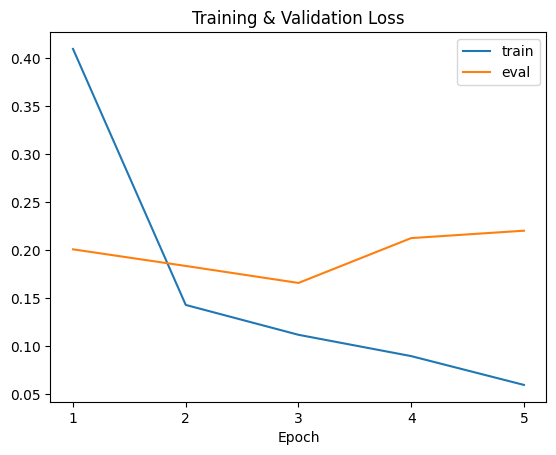

In [25]:
plt.plot(train_loss_lists, label='train')
plt.plot(eval_loss_lists, label='eval')
plt.title('Training & Validation Loss')
plt.xticks(np.arange(len(train_loss_lists)), np.arange(1, len(eval_loss_lists)+1))
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

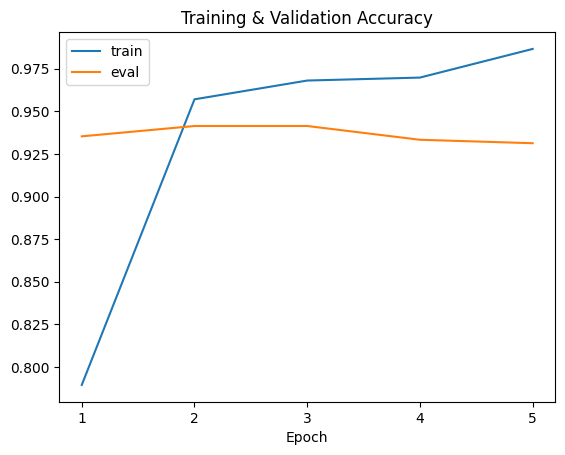

In [26]:
plt.plot(train_acc_lists, label='train')
plt.plot(eval_acc_lists, label='eval')
plt.title('Training & Validation Accuracy')
plt.xticks(np.arange(len(train_acc_lists)), np.arange(1, len(eval_acc_lists)+1))
plt.legend()
plt.xlabel('Epoch')

In [27]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction

  0%|          | 0/31 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


In [28]:
list_hyp, list_label

(['ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  

In [29]:
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
metrics

{'ACC': 0.9467213114754098,
 'F1': 0.9451732780226428,
 'REC': 0.9408668307355756,
 'PRE': 0.95227575566309}

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_label, list_hyp)

cm

array([[136,   2],
       [ 11,  95]])

In [31]:
report = classification_report(list_label, list_hyp, digits=4)

print(report)

              precision    recall  f1-score   support

   ihsg naik     0.9252    0.9855    0.9544       138
  ihsg turun     0.9794    0.8962    0.9360       106

    accuracy                         0.9467       244
   macro avg     0.9523    0.9409    0.9452       244
weighted avg     0.9487    0.9467    0.9464       244

